## Hidden sampling experiment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from scipy.stats import normaltest
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.interpolate import interp1d
from scipy.integrate import quad
from pathlib import Path
from sklearn.metrics import r2_score
from sklearn.linear_model import HuberRegressor

import warnings
warnings.filterwarnings("ignore")

%cd ..

/Users/andrey/MIPT_projects/M1P_6_sem/2023-Project-119


In [102]:
plt.rc('axes', titlesize=25, titleweight='bold') #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=20) #fontsize of the x tick labels
plt.rc('ytick', labelsize=20) #fontsize of the y tick labels
plt.rc('legend', fontsize=25) #fontsize of the legend
plt.rc('figure', figsize=(12, 8)) # figure size

### Defining usage and adherence

In [128]:
usage = 1
adherence = 0

### Preparing data

In [129]:
# preparing our data
hidden_samples = Path(f"results/hidden_samples_e_{usage}_{adherence}")
p_values = []
f_t_list = []
steps = range(10, 10001, 10)

for folder in sorted(hidden_samples.iterdir()):
    if folder.name != '.DS_Store':
        for step in steps:
            data = pd.read_csv(f"{hidden_samples}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = data['y'] - data['y_pred']
            hst = np.histogram(data_hist, density=True, bins=200)
            f_t = interp1d(hst[1][:-1], hst[0], kind='linear', 
                           fill_value=0.0, bounds_error=False)
            _, p_value = normaltest(data['y'] - data['y_pred'])
            f_t_list.append(f_t)
            p_values.append(p_value)

In [130]:
# preparing f_t(0) and int_{-kappa}^{kappa}f_t(x)dx
f_t0_list = []
integrals = {}
kappas = [0.5, 1, 1.5]

for kappa in kappas:
    integrals[kappa] = []
    
for f_t in f_t_list:
    f_t0_list.append(float(f_t(0.)))
    for kappa in kappas:
        integral, _ = quad(f_t, -kappa, kappa)
        integrals[kappa].append(integral)

### Normatity test

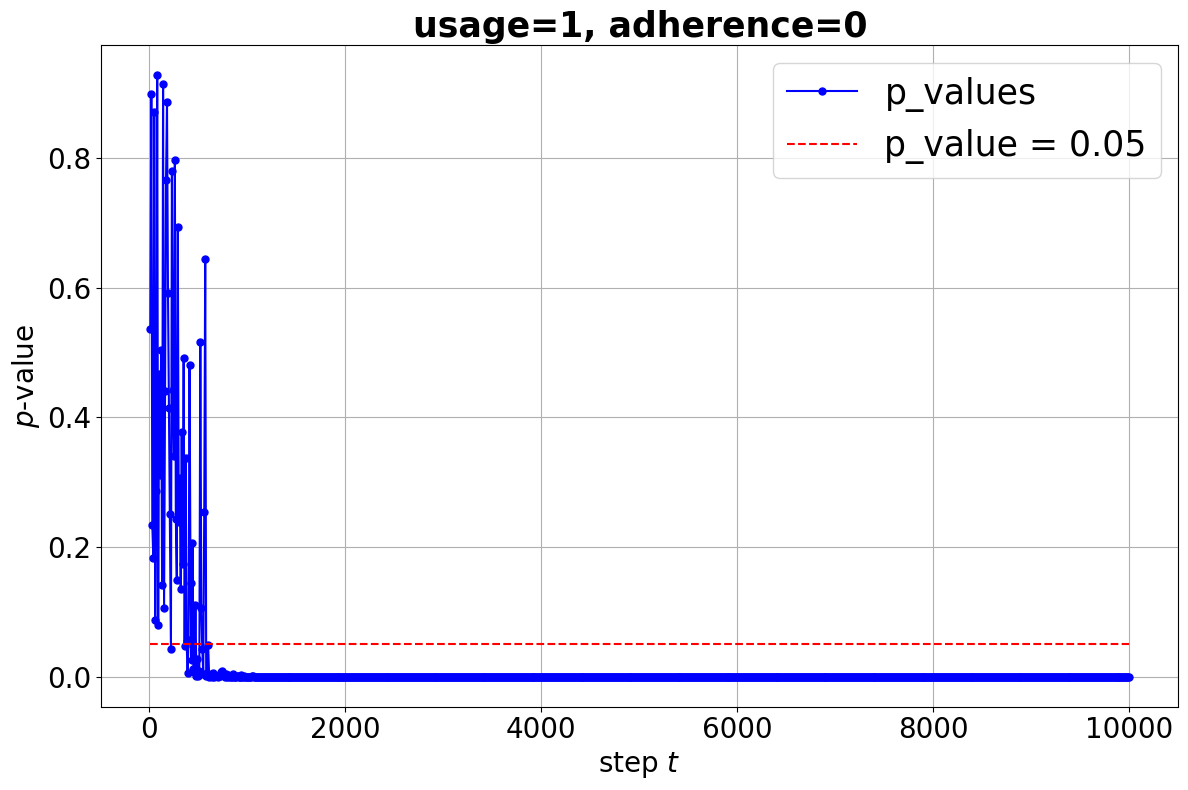

In [108]:
# plot means, deviations and p_values
plt.title(f"usage={usage}, adherence={adherence}")

plt.xlabel(r"step $t$")
plt.ylabel(r"$p$-value")

plt.plot(steps, p_values, label = "p_values", 
           color="blue", marker='o', markersize=5)
plt.plot(steps, [0.05]*len(steps), '--', color="red", label="p_value = 0.05")

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/p_sample_{usage}_{adherence}.png")
plt.show()

### Making hists

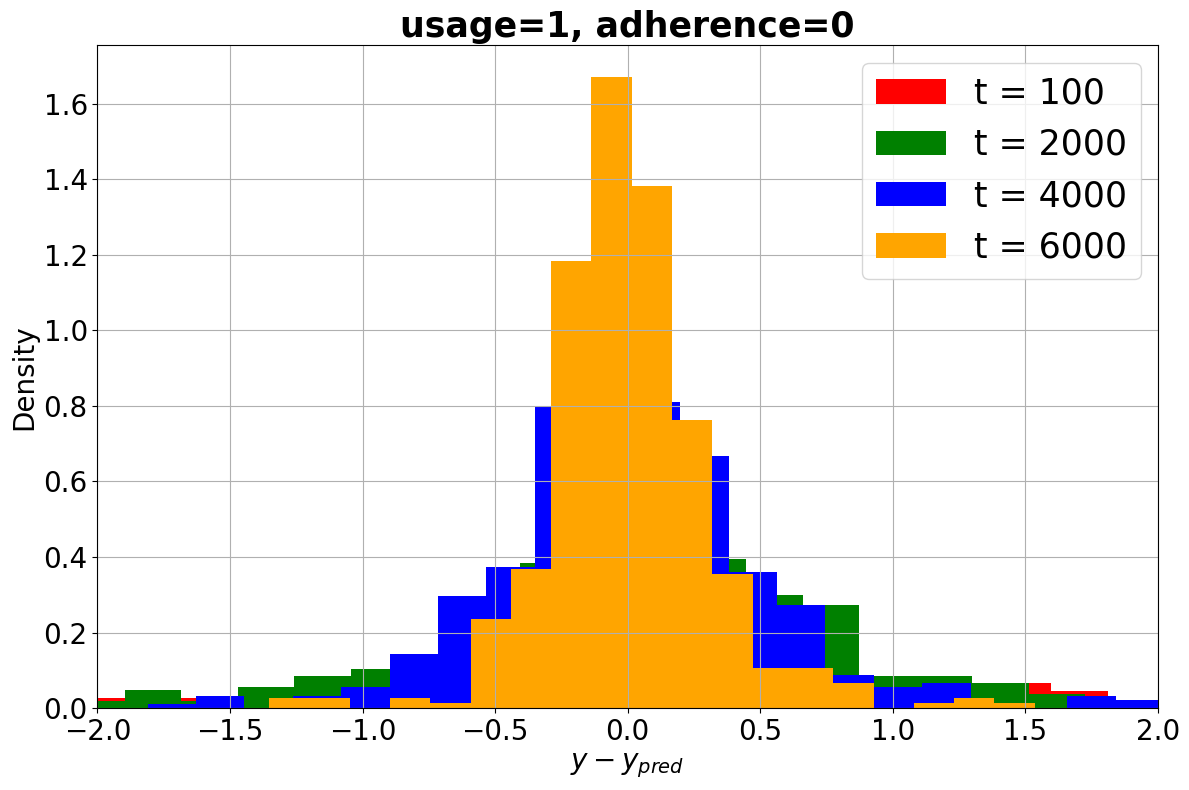

In [109]:
# plot histograms
plt.title(f"usage={usage}, adherence={adherence}")
plt.xlabel(r"$y - y_{pred}$")
plt.ylabel("Density")
plt.xlim((-2, 2))

colors = ['red', 'green', 'blue', 'orange', 'purple',
          'cyan', 'pink', 'brown', 'black', 'olive']

steps_hist = [100, 2000, 4000, 6000]
for folder in sorted(hidden_samples.iterdir()):
    if folder.name != '.DS_Store':
        for step, color in zip(steps_hist, colors):
            data = pd.read_csv(f"{hidden_samples}/{folder.name}/deviations/ridge-dev_step_{step}.csv")
            data_hist = np.array(data['y'] - data['y_pred'])
            hst = np.histogram(data_hist, density=True, bins=30)
            plt.hist(data_hist, bins=250, label=f"t = {step}", color=color,
                     density=True, stacked=True)
            f_t = interp1d(hst[1][:-1], hst[0], kind='cubic', 
                           fill_value=0.0, bounds_error=False)
            x_axis = np.linspace(-2, 2, 3000)
            #plt.plot(x_axis, f_t(x_axis), label=f"t = {step}", color=color)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/hist_sample_{usage}_{adherence}.png")
plt.show()

### Limit to delta function

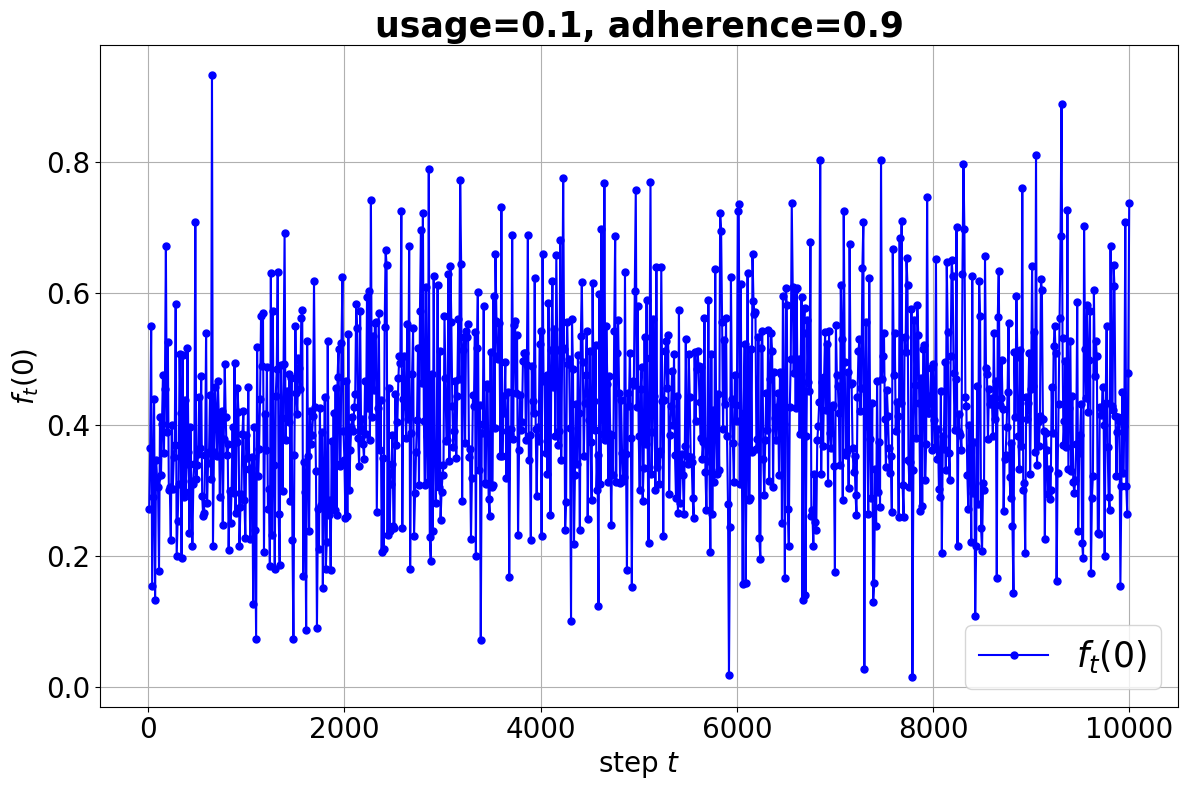

In [132]:
# plot f_t(0)
plt.title(f"usage={usage}, adherence={adherence}")
plt.xlabel(r"step $t$")
plt.ylabel(r"$f_t(0)$")
plt.plot(steps, f_t0_list, label = r"$f_t(0)$", 
         color="blue", marker='o', markersize=5)
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/ft0_sample_{usage}_{adherence}.png")
plt.show()

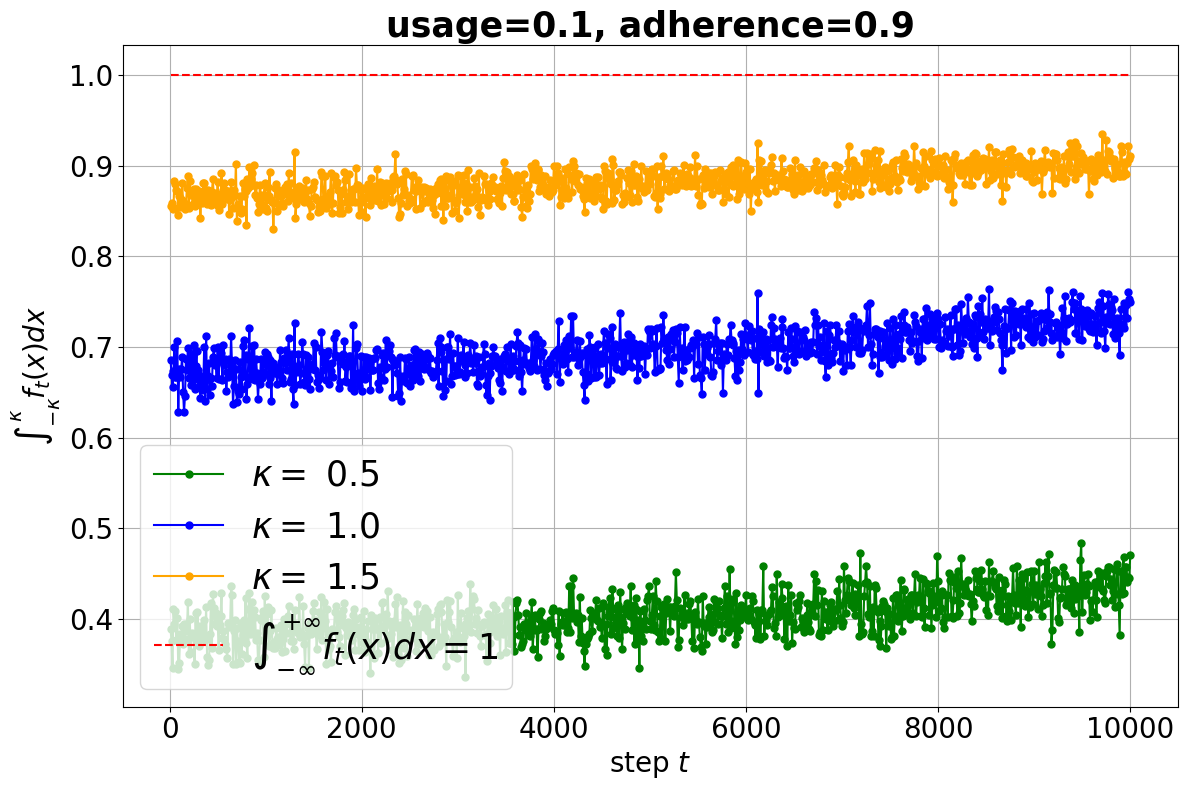

In [134]:
# plot int_{-kappa}^{kappa}f_t(x)dx
plt.title(f"usage={usage}, adherence={adherence}")
plt.xlabel(r"step $t$")
plt.ylabel(r"$\int_{-\kappa}^{\kappa}f_t(x)dx$")

colors = ['green', 'blue', 'orange']
for kappa, color in zip(integrals.keys(), colors):
    plt.plot(steps, integrals[kappa],
             label = r"$\kappa = $ %.1f" % kappa,
             color=color, marker='o', markersize=5)
plt.plot(steps, [1]*len(steps), '--', color="red",
         label=r"$\int_{-\infty}^{+\infty}f_t(x)dx = 1$")
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/int_sample_{usage}_{adherence}.png")
plt.show()

### Semigroup chek

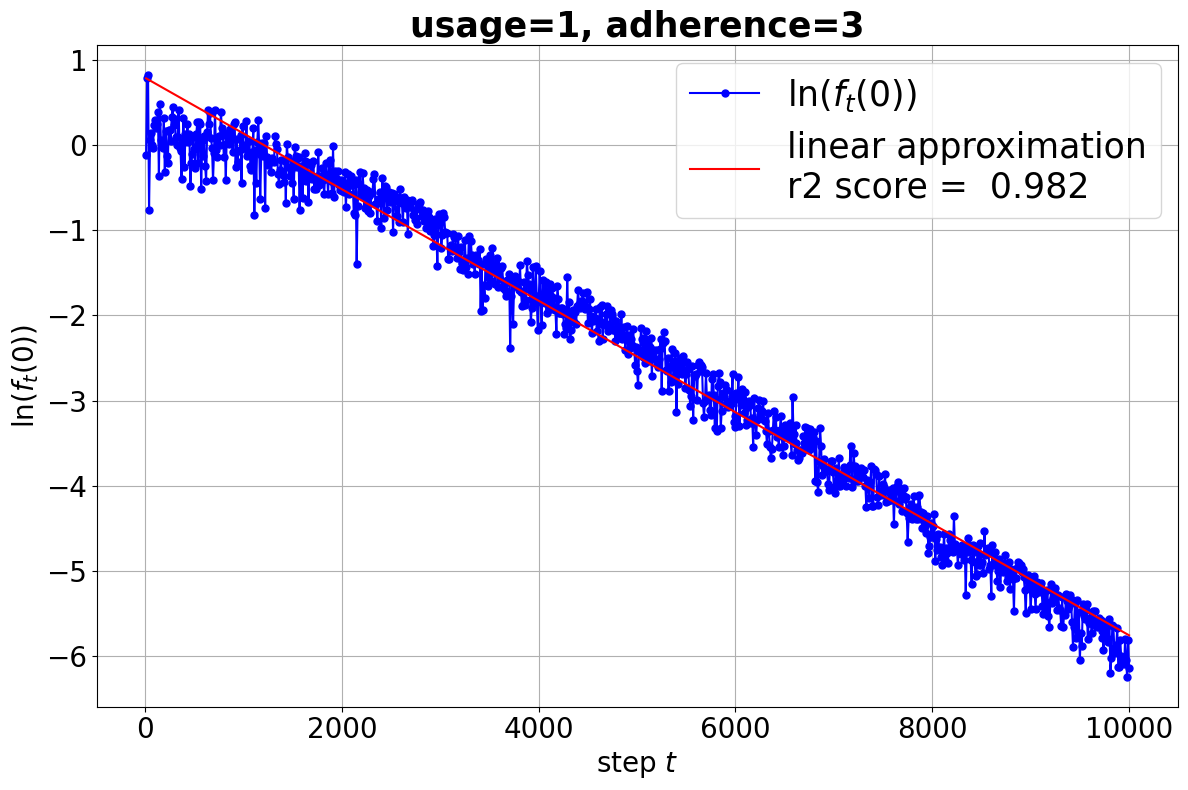

In [126]:
# plot ln(f_t(0)) 
plt.title(f"usage={usage}, adherence={adherence}")

plt.xlabel(r"step $t$")
plt.ylabel(r"$\ln(f_t(0))$")
plt.plot(steps, np.log(f_t0_list), label = r"$\ln(f_t(0))$", 
         color="blue", marker='o', markersize=5)

huber = HuberRegressor().fit(np.array(steps).reshape(-1, 1), np.log(f_t0_list))
k = huber.coef_[0]
b = huber.intercept_
r2score = r2_score(np.log(f_t0_list), k * steps + b)

plt.plot(steps, k*steps + b, '-', color='red', 
         label='linear approximation\nr2 score =  %.3f' % r2score)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/semigroup_sample_{usage}_{adherence}.png")
plt.show()

In [127]:
# test for heteroscedasticity
tol = 1.
residuals = (np.log(f_t0_list) - k * steps - b)
x = steps

_, p_val, _, _ = het_breuschpagan(residuals, list(zip(np.ones_like(x), x)))

print(f'p_value = %.20f, homoscedasticity: {p_val < 0.05}' % p_val)
# mse
print('mse = %.3f' % mse(np.log(f_t0_list), k * steps - b))

p_value = 0.00000000000000000178, homoscedasticity: True
mse = 2.502


### Moments

In [98]:
# functions to calculate k-th moments
def k_moment(k, func):
    new_func = lambda x : x**k * func(x)
    integral, _ = quad(new_func, -np.inf, np.inf)
    return integral

In [99]:
# prepare moments_k(t)
N = 5
moments = {}
for k in range(1, N+1):
    moments[k] = []
    for f_t in f_t_list:
        moment_t = k_moment(k, f_t)
        moments[k].append(moment_t)

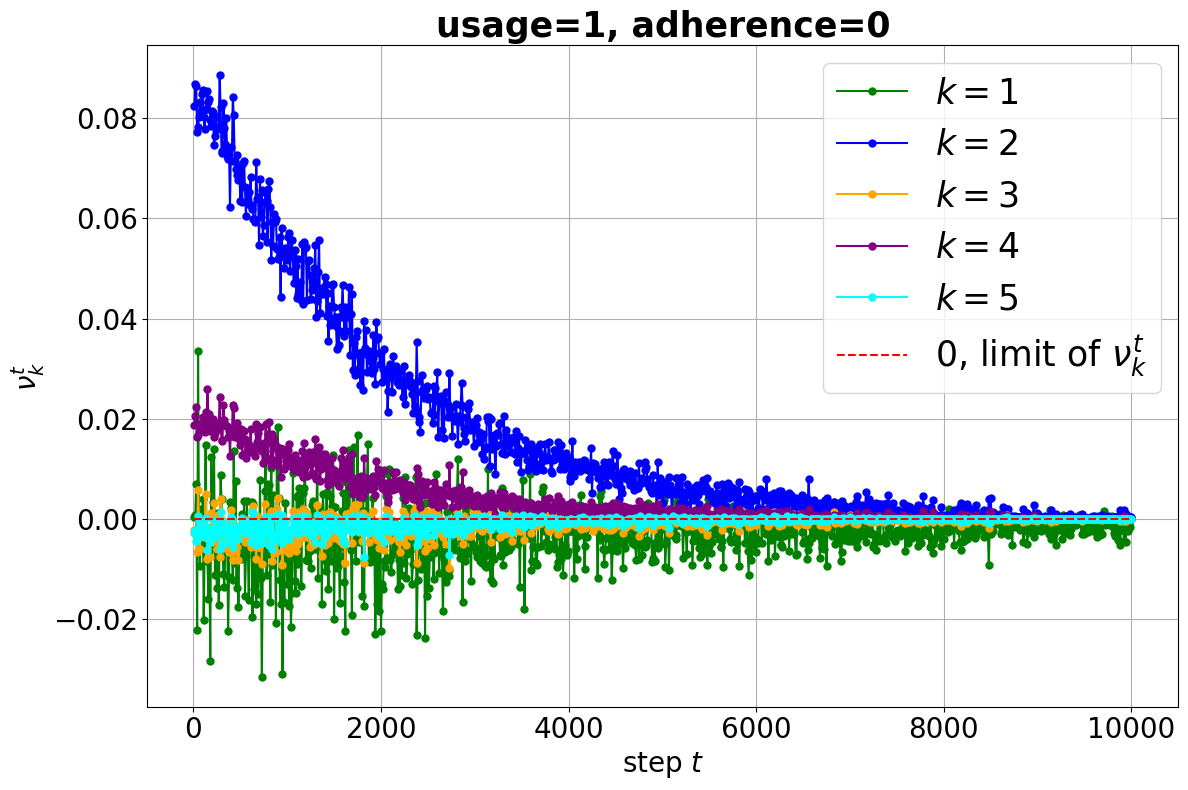

In [101]:
# plot moment_k(t)
colors = ['green', 'blue', 'orange', 'purple', 'cyan']
plt.title(f"usage={usage}, adherence={adherence}")

plt.xlabel(r"step $t$")
plt.ylabel(r"$\nu_k^t$")

for k, moment_t, color in zip(moments.keys(), moments.values(), colors):
    plt.plot(steps, moment_t, label = r"$k = %i$" % k,
                 color=color, marker='o', markersize=5)

plt.plot(steps, [0]*len(steps), '--', label = r"0, limit of $\nu_k^t$",
         color="red")
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig(f"figures/moments_sample_{usage}_{adherence}.png")
plt.show()